# Laboratory #3 : Face detection and recognition

At the end of this laboratory, you would get familiarized with

*   Face detection
    *   Integral images
    *   Haar-like feature computation
    *   Adaboost 
*   Face recognition
    *   Eigen Faces
    *   PCA and LDA

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Mount your drive to access the images.
*   Add sufficient comments and explanations wherever necessary.

---

**Authors**
- Joaquim Marset Alsina
- Jesús Molina Rodríguez de Vera

In [ ]:
# mount drive to the notebook

from google.colab import drive
drive.mount('/content/drive')

# Face Detection using AdaBoost

In [ ]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

import numpy as np
from skimage import data, io, img_as_float
import os
import matplotlib
from PIL import Image
from multiprocessing import Pool
from functools import partial
import time
import timeit
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

### Exercise #1

*   Build a function compute_integral_image that computes the integral image of an input (2D) array. In an integral image each pixel is the sum of all pixels in the original image that are 'left and above' the pixel. See the following example:

```
Original    Integral
+--------   +------------
| 1 2 3 .   | 0  0  0  0 .
| 4 5 6 .   | 0  1  3  6 .
| . . . .   | 0  5 12 21 .
            | . . . . . .
```

*   The integral image must have an additional row and column full of zeros (first row and first column).
*   Plot the output of the integral image for the following array:

```
img_array = np.array([[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1]])
```

In [ ]:
def compute_integral_image(img_arr):
    """
    Calculates the integral image based on the original image data.
    :param img_arr: Image source data
    :type img_arr: numpy.ndarray
    :return Integral image for given image
    :rtype: numpy.ndarray
    """
    # an index of -1 refers to the last row/column
    # since row_sum is calculated starting from (0,0),
    # rowSum(x, -1) == 0 holds for all x
    row_sum = np.zeros(img_arr.shape)
    # we need an additional column and row
    integral_image_arr = np.zeros((img_arr.shape[0] + 1, img_arr.shape[1] + 1))

    # Add code here    
    integral_image_arr[1:,1:] = np.cumsum(np.cumsum(img_arr, axis=1), axis=0)
    


    return integral_image_arr

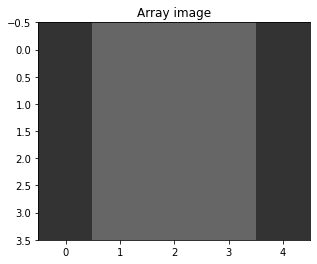

In [ ]:
img_array = np.array([[1, 2, 2, 2, 1], [1, 2, 2, 2, 1], [1, 2, 2, 2, 1], [1, 2, 2, 2, 1]])
plt.imshow(img_array, cmap="gray", vmin=0, vmax= 5)
plt.title("Array image")
plt.show()

In [ ]:
ii_img_array = compute_integral_image(img_array)
print(ii_img_array)

[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  1.  3.  5.  7.  8.]
 [ 0.  2.  6. 10. 14. 16.]
 [ 0.  3.  9. 15. 21. 24.]
 [ 0.  4. 12. 20. 28. 32.]]


*   Test the function using 'camera' image from the data module. Plot the original image and the integral image.

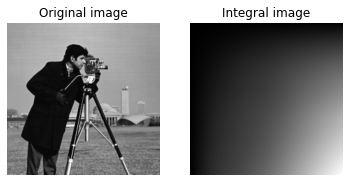

In [ ]:
# solution

camera_img = data.camera()

fig, axes = plt.subplots(1,2)

for ax in axes.flatten():
    ax.axis('off')

axes[0].imshow(camera_img, cmap="gray")
axes[0].set_title("Original image")
axes[1].imshow(compute_integral_image(camera_img), cmap="gray")
axes[1].set_title("Integral image");

### Exercise #2

*   Create a function sum_region to compute the sum of the pixel intensities within a rectangle using the integral image. The rectangle will be defined using the top left (x, y) and bottom right (x, y) coordinates.

In [ ]:
def sum_region(integral_img_arr, top_left, bottom_right):
    (x1,y1) = top_left
    (x2,y2) = bottom_right
    return integral_img_arr[x2, y2] + integral_img_arr[x1,y1] - integral_img_arr[x2,y1] - integral_img_arr[x1,y2]

*   Make the following tests:

In [ ]:
# result you should get (12)
print(sum_region(ii_img_array, [1, 1], [3, 4]))

12.0


In [ ]:
# result you should get (32)
print(sum_region(ii_img_array, [0, 0], [-1, -1]))

32.0


### Exercise #3

*   Build a function load_integral_images to read all the images inside a given folder and compute the integral image of every image

In [ ]:
def load_integral_images(path):
    images = []
    ii_images = []
    for _file in os.listdir(path):
        if ".png" in _file or ".jpg" in _file:
        
            #### Complete here:
            #### Read image
            #### Remember to scale the images (with the max pixel intensity value)
            img = io.imread(os.path.join(path, _file))
            img = img_as_float(img)
            images.append(img)
            integral_img = compute_integral_image(img)            
            maximum = np.amax(integral_img)
            if maximum!=0:
                integral_img = integral_img/maximum
            ii_images.append(integral_img)

    return images, ii_images


# With this function we are reading each file in the folder, calculating its integral image and after that normalizing the image.
# Finally we put our processed image in the list that we will return

*   Use the load_integral_images function to compute the integral images of training and testing data

In [ ]:
# change paths to your location

root_dir = r'images'

pos_training_path = os.path.join(root_dir, 'train_data/faces')
neg_training_path = os.path.join(root_dir, 'train_data/non_faces')
pos_testing_path = os.path.join(root_dir, 'test_data/faces')
neg_testing_path = os.path.join(root_dir, 'test_data/non_faces')

In [ ]:
# solution

pos_training_images, pos_training_iis = load_integral_images(pos_training_path)
pos_testing_images, pos_testing_iis = load_integral_images(pos_testing_path)
neg_training_images, neg_training_iis = load_integral_images(neg_training_path)
neg_testing_images, neg_testing_iis = load_integral_images(neg_testing_path)

*   Visualize a few original images and the corresponding integral images using matplotlib.

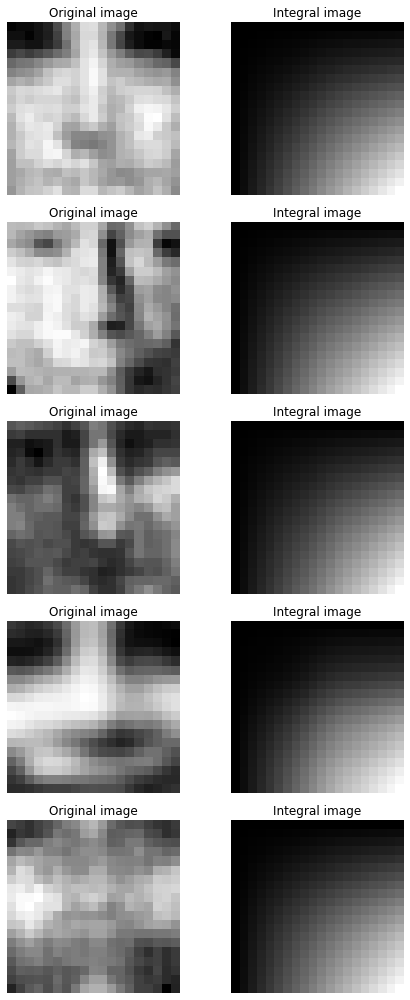

In [ ]:
# solution

fig, axes = plt.subplots(5, 2)

fig.set_size_inches(7,14)

for ax in axes.flatten():
    ax.axis("off")

for i, (img, ii) in enumerate(zip(pos_testing_images[:5], pos_testing_iis[:5])):
    ax1 = axes[i,0]
    ax2 = axes[i,1]
    ax1.imshow(img, cmap="gray")
    ax1.set_title("Original image")
    ax2.imshow(ii, cmap='gray')
    ax2.set_title("Integral image")

fig.tight_layout()

### Exercise #4

*   Compute the Haar features of an image.
*   We provide you with HaarLikeFeature class that has build in a get_score function and a get_vote function. Your job is to complete the code of the method _create_features in the class HaarLikeFeature:

In [ ]:
def enum(**enums):
    return type('Enum', (), enums)

FeatureType = enum(TWO_VERTICAL=(1, 2), TWO_HORIZONTAL=(2, 1), THREE_HORIZONTAL=(3, 1), THREE_VERTICAL=(1, 3), FOUR=(2, 2))
FeatureTypes = [FeatureType.TWO_VERTICAL, FeatureType.TWO_HORIZONTAL, FeatureType.THREE_VERTICAL, FeatureType.THREE_HORIZONTAL, FeatureType.FOUR]

In [ ]:
class HaarLikeFeature(object):
    """
    Class representing a haar-like feature.
    """

    def __init__(self, feature_type, position, width, height, threshold, polarity):
        """
        Creates a new haar-like feature.
        :param feature_type: Type of new feature, see FeatureType enum
        :type feature_type: HaarLikeFeature.FeatureTypes
        :param position: Top left corner where the feature begins (x, y)
        :type position: (int, int)
        :param width: Width of the feature
        :type width: int
        :param height: Height of the feature
        :type height: int
        :param threshold: Feature threshold
        :type threshold: float
        :param polarity: polarity of the feature -1 or 1
        :type polarity: int
        """
        self.type = feature_type
        self.top_left = position
        self.bottom_right = (position[0] + width, position[1] + height)
        self.width = width
        self.height = height
        self.threshold = threshold
        self.polarity = polarity
        self.weight = 1
    
    def get_score(self, int_img):
        """
        Get score for given integral image array.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray
        
        :return: Score for given feature
        :rtype: float
        """
        score = 0
        if self.type == FeatureType.TWO_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.top_left[0] + self.width, int(self.top_left[1] + self.height / 2)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.TWO_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.THREE_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 3), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 3), self.top_left[1]), (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1] + self.height))
            third = sum_region(int_img, (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1]), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.THREE_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.bottom_right[0], int(self.top_left[1] + self.height / 3)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 3)), (self.bottom_right[0], int(self.top_left[1] + 2 * self.height / 3)))
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + 2 * self.height / 3)), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.FOUR:
            # top left area
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)))
            # top right area
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), (self.bottom_right[0], int(self.top_left[1] + self.height / 2)))
            # bottom left area
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), (int(self.top_left[0] + self.width / 2), self.bottom_right[1]))
            # bottom right area
            fourth = sum_region(int_img, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second - third + fourth
        return score
    
    def get_vote(self, int_img):
        """
        Get vote of this feature for given integral image.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray
        
        :return: 1 iff this feature votes positively, otherwise -1
        :rtype: int
        """
        score = self.get_score(int_img)
        return self.weight * (1 if score < self.polarity * self.threshold else -1)

In [ ]:
def learn(positive_iis, negative_iis, num_classifiers=-1, min_feature_width=1, max_feature_width=-1, min_feature_height=1, max_feature_height=-1):
    """
    Selects a set of classifiers. Iteratively takes the best classifiers based
    on a weighted error.
    :param positive_iis: List of positive integral image examples
    :type positive_iis: list[numpy.ndarray]
    :param negative_iis: List of negative integral image examples
    :type negative_iis: list[numpy.ndarray]
    :param num_classifiers: Number of classifiers to select, -1 will use all
    classifiers
    :type num_classifiers: int
    
    :return: List of selected features
    :rtype: list[HaarLikeFeature.HaarLikeFeature]
    """
    num_pos = len(positive_iis)
    num_neg = len(negative_iis)
    num_imgs = num_pos + num_neg
    img_height, img_width = positive_iis[0].shape

    # Maximum feature width and height default to image width and height
    max_feature_height = img_height if max_feature_height == -1 else max_feature_height
    max_feature_width = img_width if max_feature_width == -1 else max_feature_width

    # Create initial weights and labels
    pos_weights = np.ones(num_pos) * 1. / (2 * num_pos)
    neg_weights = np.ones(num_neg) * 1. / (2 * num_neg)
    weights = np.hstack((pos_weights, neg_weights))
    labels = np.hstack((np.ones(num_pos), np.ones(num_neg) * -1)) 

    images = positive_iis + negative_iis

    # Create features for all sizes and locations
    features = _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height)
    num_features = len(features)
    feature_indexes = list(range(num_features))

    num_classifiers = num_features if num_classifiers == -1 else num_classifiers

    print('Calculating scores for images..')
    t0 = time.time()
    votes = np.zeros((num_imgs, num_features))
    # Use as many workers as there are CPUs
    pool = Pool(processes=8)
    for i in range(num_imgs):
        votes[i, :] = np.array(list(pool.map(partial(_get_feature_vote, image=images[i]), features)))

    
    print('\tTime needed for calculating scores:', time.time()-t0)
    
    # select classifiers
    classifiers = []

    t0 = time.time()
    print('Selecting classifiers..')
    for _ in range(num_classifiers):

        classification_errors = np.zeros(len(feature_indexes))

        # normalize weights
        weights *= 1. / np.sum(weights)

        # select best classifier based on the weighted error
        for f in range(len(feature_indexes)):
            f_idx = feature_indexes[f]
            # classifier error is the sum of image weights where the classifier
            # is right
            error = sum(map(lambda img_idx: weights[img_idx] if labels[img_idx] != votes[img_idx, f_idx] else 0, range(num_imgs)))
            classification_errors[f] = error

        # get best feature, i.e. with smallest error
        min_error_idx = np.argmin(classification_errors)
        best_error = classification_errors[min_error_idx]
        best_feature_idx = feature_indexes[min_error_idx]

        # set feature weight
        best_feature = features[best_feature_idx]
        feature_weight = 0.5 * np.log((1 - best_error) / best_error)
        best_feature.weight = feature_weight

        classifiers.append(best_feature)

        # update image weights
        weights = np.array(list(map(lambda img_idx: weights[img_idx] * np.sqrt((1-best_error)/best_error) if labels[img_idx] != votes[img_idx, best_feature_idx] else weights[img_idx] * np.sqrt(best_error/(1-best_error)), range(num_imgs))))

        # remove feature (a feature can't be selected twice)
        feature_indexes.remove(best_feature_idx)

    print('\tTime needed for Selecting Classifiers:', time.time()-t0,'\n')

    return classifiers


def _get_feature_vote(feature, image):
    return feature.get_vote(image)


def _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height):
    print('Creating Haar-like features..')
    t0 = time.time()
    features = []
    for feature in FeatureTypes:
        # FeatureTypes are just tuples
        feature_start_width = max(min_feature_width, feature[0])
        for feature_width in range(feature_start_width, max_feature_width, feature[0]):
            feature_start_height = max(min_feature_height, feature[1])
            for feature_height in range(feature_start_height, max_feature_height, feature[1]):
                # Loop over possible x values and y values 
                # - For each (x,y) create the HarrLikeFeature objects.
                # - append the HaarlikeFeatures in the features list.
                for x in range(img_width-feature_width):
                    for y in range(img_height-feature_height):
                        features.append(HaarLikeFeature(feature, (x, y), feature_width, feature_height, 0, 1))
                        features.append(HaarLikeFeature(feature, (x, y), feature_width, feature_height, 0, -1))
            
    print('\t' + str(len(features)) + ' features created.')
    print('\tTime needed for calculating Haar-like features:', time.time()-t0)
    return features

### Exercise #5

*   Use the learn method to learn a list of two classifiers with the train data. With the learn function you can build a list of classifiers that detect whether an image contains a face or not.

*   Use the following hyperparameters of the features and num_classifiers

In [ ]:
num_classifiers = 2
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [ ]:
%%time 

classifiers = learn(pos_training_iis, neg_training_iis, num_classifiers, min_feature_width, max_feature_width, min_feature_height, max_feature_height)

Creating Haar-like features..
	2496 features created.
	Time needed for calculating Haar-like features: 0.012301445007324219
Calculating scores for images..
	Time needed for calculating scores: 68.87574362754822
Selecting classifiers..
	Time needed for Selecting Classifiers: 18.781365633010864 

CPU times: user 1min 23s, sys: 5.44 s, total: 1min 29s
Wall time: 1min 27s


### Exercise #6

*   Make a function for voting with different classifiers
*   Build two functions ensemble_vote and ensemble_vote_all.
*   **ensemble_vote(int_img, classifiers)** has to return a 1 if the majority of the votes of the classifiers is positive and a zero otherwise
*   **ensemble_vote_all(int_imgs, classifiers)** has to loop over the list int_imgs and compute the ensemble_vote for each image in the list. It has to return a list containing all the votes for all the images in int_imgs.


In [ ]:
# solution
def ensemble_vote(int_img, classifiers):
    return 1 if sum([c.get_vote(int_img) for c in classifiers]) > 0 else 0


def ensemble_vote_all(int_imgs, classifiers):
    return [ensemble_vote(int_img, classifiers=classifiers) for int_img in int_imgs]

*   Use the functions to compute the train and test acurracies for faces and non faces.
*   Print the results in the following format:

```
train results:
Correctly identified Faces: 2129/2429  (87.64923836969946%)
Correctly identified non-Faces: 4276/8548  (50.02339728591484%)

test results:
Correctly identified Faces: 300/472  (63.559322033898304%)
Correctly identified non-Faces: 74/128  (57.8125%)
```

*   It is not required to get this exact results but print the information in this format. It facilitates understanding the results.

In [ ]:
# solution

def print_results(classifiers, pos_iis, neg_iis):
    true_positives = sum(ensemble_vote_all(pos_iis, classifiers))
    true_negatives = len(neg_iis) - sum(ensemble_vote_all(neg_iis, classifiers))
    print(f"Correctly identified Faces: {true_positives}/{len(pos_iis)}  ({100*true_positives/len(pos_iis)}%)")
    print(f"Correctly identified non-Faces: {true_negatives}/{len(neg_iis)} ({100*true_negatives/len(neg_iis)}%)")

print("train results:")
print_results(classifiers, pos_training_iis, neg_training_iis)
print("")
print("test results:")
print_results(classifiers, pos_testing_iis, neg_testing_iis)

train results:
Correctly identified Faces: 2128/2429  (87.60806916426513%)
Correctly identified non-Faces: 4273/8555 (49.94739918176505%)

test results:
Correctly identified Faces: 299/472  (63.347457627118644%)
Correctly identified non-Faces: 75/128 (58.59375%)


### Exercise #7

*   Make another test with 20 classifiers instead of 2.
*   Inspect the classification results if you use adaboost with 20 classifiers. *   Use the same hyperameters for the features. Print the results as in the previous exercise.

In [ ]:
num_classifiers = 20
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [ ]:
%%time 

classifiers = learn(pos_training_iis, neg_training_iis, num_classifiers, min_feature_width, max_feature_width, min_feature_height, max_feature_height)

Creating Haar-like features..
	2496 features created.
	Time needed for calculating Haar-like features: 0.01281428337097168
Calculating scores for images..
	Time needed for calculating scores: 68.9334888458252
Selecting classifiers..
	Time needed for Selecting Classifiers: 193.72408652305603 

CPU times: user 4min 19s, sys: 5.42 s, total: 4min 24s
Wall time: 4min 22s


In [ ]:
print("train results:")
print_results(classifiers, pos_training_iis, neg_training_iis)
print("")
print("test results:")
print_results(classifiers, pos_testing_iis, neg_testing_iis)

train results:
Correctly identified Faces: 2225/2429  (91.60148209139564%)
Correctly identified non-Faces: 7109/8555 (83.09760374050263%)

test results:
Correctly identified Faces: 247/472  (52.33050847457627%)
Correctly identified non-Faces: 102/128 (79.6875%)


*   Discuss if the classification results improved in the train data.


**Solution**

The classification results have improved after this change (specially regarding the non-faces classification). That is because, the higher the number of classifiers, the easier it is for the model to fit to the training data. The different classifiers can "detect" different features of the images and complement each other. In other words, the system is more complex and therefore, more capable of dealing with the training data.

However, thre is a trade-off between the complexity of the model and its generalisation abitility (overfitting might occur). We don't know if it is the case in our particular situation, given that the results for the faces in the test set is worse but there is also a great improvement regarding the non-faces. Thus, it looks like the usage of more classifiers has led to a a better system that is still able to generalise.

### Exercise #8

*   Change the voting functions so that you can set a threshold for deciding a prediction.
*   The threshold value indicates the minimum score for assigning a "positive" label (detect a face).
*   Create the following functions
    *   ensemble_vote_t: returns the final decision of a list of classifiers for a given threshold.
    *   ensemble_vote_all_t: Iterates over a list of integral images and returns the final decision of a list of classifiers for each of the images (for a given threshold).

In [ ]:
# solution
def ensemble_vote_t(int_img, classifiers, threshold):
    return 1 if sum([c.get_vote(int_img) for c in classifiers]) > threshold else 0


def ensemble_vote_all_t(int_imgs, classifiers, threshold):
    return [ensemble_vote_t(int_img, classifiers, threshold) for int_img in int_imgs]

*   Using the list of 20 classifiers compute the following:

    1.   number of correct faces over all faces (in the train data)
    2.   number of correct non faces over all non faces (in the train data)
    3.   number of correct faces over all faces (in the test data)
    4.   number of correct non faces over all non faces (in the test data)

*   The quantities have to be computed for each of the following thresholds:
```
thresholds = np.array([x for x in range(-5,5,1)])/10.
```

In [ ]:
def compute_results_t(classifiers, pos_iis, neg_iis, threshold):
    true_positives = sum(ensemble_vote_all_t(pos_iis, classifiers, threshold))
    true_negatives = len(neg_iis) - sum(ensemble_vote_all_t(neg_iis, classifiers, threshold))
    return 100*true_positives/len(pos_iis), 100*true_negatives/len(neg_iis)

In [ ]:
# solution

thresholds = np.array([x for x in range(-5,5,1)])/10
results = []
for t in thresholds:
    acc_faces, acc_non_faces= compute_results_t(classifiers, pos_training_iis, neg_training_iis, t)
    results.append({
        "Threshold": t,
        "Set": "training",
        "Variable": "Acc. Faces",
        "Value (%)": acc_faces,
    })
    results.append({
        "Threshold": t,
        "Set": "training",
        "Variable": "Acc. Non-Faces",
        "Value (%)": acc_non_faces
    })

    acc_faces, acc_non_faces= compute_results_t(classifiers, pos_testing_iis, neg_testing_iis, t)
    results.append({
        "Threshold": t,
        "Set": "testing",
        "Variable": "Acc. Faces",
        "Value (%)": acc_faces,
    })
    results.append({
        "Threshold": t,
        "Set": "testing",
        "Variable": "Acc. Non-Faces",
        "Value (%)": acc_non_faces
    })
df_results = pd.DataFrame(results)
df_results.head()

,Threshold,Set,Variable,Value (%)
0,-0.5,training,Acc. Faces,97.571017
1,-0.5,training,Acc. Non-Faces,68.813559
2,-0.5,testing,Acc. Faces,73.516949
3,-0.5,testing,Acc. Non-Faces,65.625000
4,-0.4,training,Acc. Faces,96.500618


*   Make a bar plot for 1-4. In the x axis write the threshold value.

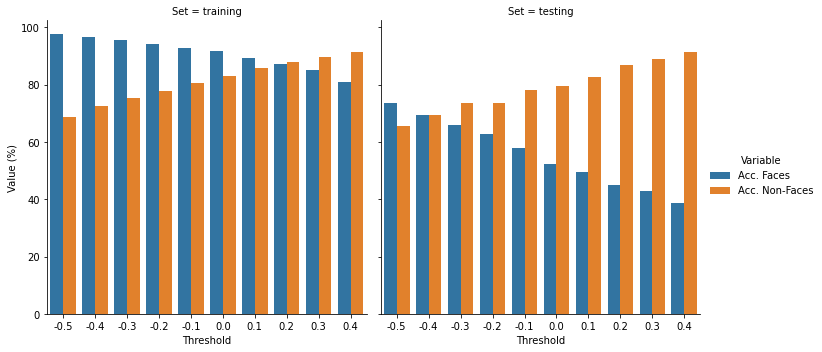

In [ ]:
# solution

sns.catplot(data=df_results, x="Threshold", y="Value (%)", hue="Variable", kind="bar", col="Set", sharey=True);

*   Discuss what happens when you increase the threshold value.

**Solution**

As we increase the threshold, it is "more difficult" for the system to clasify an image as face. This leads to 2 effects that can be appreciated in both sets (training and testing):
- The faces precision descreases.
- The non-faces precision increases.

This result was to be expected. The lower the threshold, the more images will be classified as faces. Even if some of the new detected faces are wrong, this does not affect the face precision, that grows because some faces that had been ignored are now find. The opposite happens with the high thresholds and the precision of the non-faces.

# Face Recognition using PCA


In [ ]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

from time import time
import logging
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

*   Loading the dataset

In [ ]:
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


*   Creating training and testing set

In [ ]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print('Train data shape:', X_train.shape)
print('Test data shape:', X_test.shape)
print('Number of classes in Train set:', np.unique(y_train).shape[0])

Train data shape: (966, 1850)
Test data shape: (322, 1850)
Number of classes in Train set: 7


### Exercise #1: PCA Computation
*   Compute a PCA (eigenfaces) on the face dataset
    *   *Set* number of components to 100

PCA, as other machine learning algorithms, is affected by the scale of the data. That is, if we have some variable that it is in a different scale, and it presents values biggers than the rest because of this different scale, the results of PCA will be affected. The principal components are a linear combination of the original features, meaning that a feature with a bigger scale will have more importance, and the principal components will be biased towards those features. For example, if we have only one variable that has a bigger scale than the others, the resulting first principal component will point to the direction of the variance of that variable, meaning that it will only explain that variable and ignore the rest [Importance of scale](https://stats.stackexchange.com/questions/53/pca-on-correlation-or-covariance).

For this particular exercise, we are dealing with images, where each feature (i.e. pixel) is in the same scale [0, 255]. For this reason, we should not need to perform any kind of scaling or standarization, as we do not have the situation explained above.   
However, as each feature represents the same, being a particular pixel of the images, we will perform the standarization because we do not want some particular pixel that has more variance to be considered more important than another that may have lower variance. After all, it presents a less spreaded distribution. We want all the different pixels to be considered equal, as some particular pixel that has less variance (e.g. those pixels that are part of the eye will probably have very small values), may be equally important than other that has more variance.  
With standarization, we will achieve all the features to have the same $\sigma = 1$, so when computing PCA, we will be using the correlation matrix, as we are dividing the covariance of two features by the product of their standard deviation.

In [ ]:
# solution
scaler = StandardScaler()
standarized_X_train = scaler.fit_transform(X_train)
standarized_X_test = scaler.transform(X_test)

pca = PCA(n_components = 100)
pca.fit(standarized_X_train)

print('10 components of the first eigenvector:')
print(pca.components_[0][:10])
print()
print('5 bigger eigenvalues:')
print(pca.explained_variance_[:5])

10 components of the first eigenvector:
[-0.00475197 -0.0055023  -0.00721656 -0.00907872 -0.01057264 -0.01328487
 -0.01529267 -0.01619428 -0.01761937 -0.01916691]

5 bigger eigenvalues:
[450.01004  287.76346  135.39613   95.90259   63.120457]


*   Reshape the components output of pca to obtain the eigen faces

In [ ]:
# solution
eigenfaces = np.reshape(pca.components_, (-1, h, w))
print(eigenfaces.shape)

(100, 50, 37)


*   Project the training and testing faces data on the orthonormal basis

In [ ]:
# solution
transformed_train_data = pca.transform(standarized_X_train)
transformed_test_data = pca.transform(standarized_X_test)

*   Plot the most significative eigenfaces (Show the top 12 eigenfaces) as a matplotlib

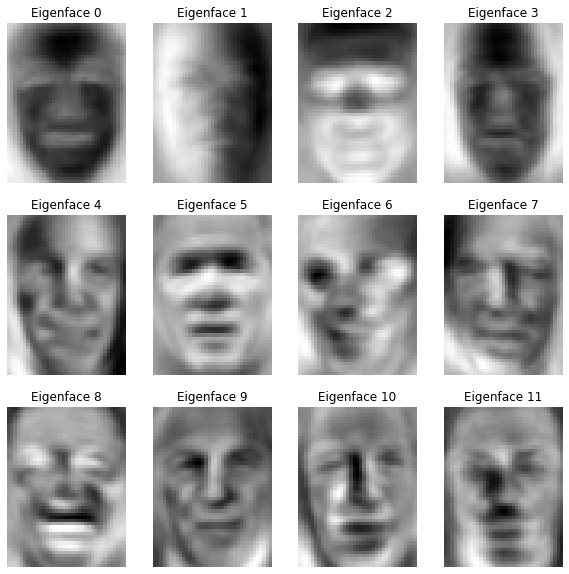

In [ ]:
# solution
fig, axs = plt.subplots(3, 4)
fig.set_size_inches(10, 10)

axs = axs.flatten()
for ax in axs:
    ax.axis('off')

# The eigenvectors are already sorted by the singular value with sklearn PCA
for i in range(12):
    axs[i].imshow(eigenfaces[i], cmap='gray')
    axs[i].set_title(f'Eigenface {i}')

plt.show()
fig.tight_layout()

*   Show the total percentage of variance explained by the selected components of the PCA.


Total explained variance ratio of the selected 100 PCs: 0.9267174005508423


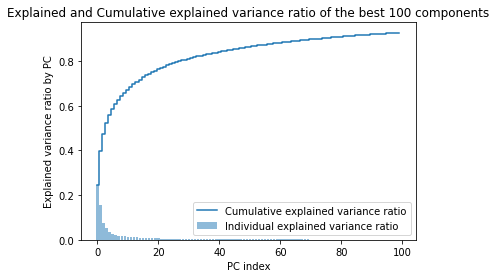

In [ ]:
# solution
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_var_ratio = np.cumsum(explained_variance_ratio)
PCs_index = range(100)

plt.bar(PCs_index, explained_variance_ratio, alpha=0.5, align='center', label='Individual explained variance ratio')
plt.step(PCs_index, cumulative_explained_var_ratio, where='mid', label='Cumulative explained variance ratio')
plt.title('Explained and Cumulative explained variance ratio of the best 100 components')
plt.ylabel('Explained variance ratio by PC')
plt.xlabel('PC index')
plt.legend(loc='best')

print(f'Total explained variance ratio of the selected 100 PCs: {cumulative_explained_var_ratio[-1]}')

*   What are the shortcomings of PCA?

**Solution**

* The main disadvantage is the fact that by keeping a reduced number of principal components, we are losing information, as we are omitting PCs that explain some variance of the original data. Typically, we should pick up several PCs that explain at least an 80%~85% of the variance. For example, in the case of the previous exercise where we picked only 12 PCs, we are only retaining the 70% of the variance, losing a considerable 30%. 

* Another important disadvantage of PCA is the fact that by transforming the original features to principal components, given that the principal components are a linear combination of the original features, they are more difficult to interpret.

* PCA generates orthogonal components, and depending on the data spreading, it is possible that those components are not able to optimally capture the variance. That is why other approaches like for example Independent Component Analysis avoid the restriction of the components to be orthogonal.

* Another problem is the fact that the principal components are linear combination of the original features. If the relation between those feature is non-linear, PCA cannot detect it, obtaining bad results.

* As seen above, PCA needs the data to be standarized to produce useful results. That is, we must ensure the different features are standarized (i.e. mean 0 and std 1) to avoid working with features that are expressed in different units and might present different scales. If this happens, the covariance matrix will present higher values for the pairs of features where one of them has a bigger scale, and the resulting principal components will be biased towards those features, even though the variance that feature creates is not that big. If we standarize them, PCA will be able to correctly find the components that best explain the variance of the input data.

* PCA needs to compute the covariance matrix, meaning that it needs to have all the data loaded in memory. If the dataset is relatively large, the dataset will not fit in memory, and PCA will not be able to execute. That is why there are modifications like Incremental PCA to solve this problem.


### Exercise #2: k-NN Classification

*   Train a k-nearest neighbor model with the eigenfaces using the default parameters

K-NN also suffers from problems of the scale of data. For example, if there is some feature that has a bigger scale than the others, when computing the distance between points, it will have a bigger effect than the others, and maybe that particular feature is not very important to separate classes.

For this reason, now that we are working with the projected data obtained from PCA, and we cannot ensure all the features are in the same scale, we are going to standarize the data to ensure we obtain the best possible results with K-NN.

In [ ]:
scaler = StandardScaler()

standarized_transformed_train = scaler.fit_transform(transformed_train_data)
standarized_transformed_test = scaler.transform(transformed_test_data)

In [ ]:
# solution
KNN = KNeighborsClassifier()
KNN.fit(standarized_transformed_train, y_train)

KNeighborsClassifier()

*   Predict the test data using the trained classifier

In [ ]:
# Quantitative evaluation of the model quality on the test set
y_predicted = KNN.predict(standarized_transformed_test)

### Exercise #3: Quantitative results

*   Compute accuracy, classification report and confusion matrix of the trained classifier

In [ ]:
# solution
accuracy_value = accuracy_score(y_test, y_predicted)
print(accuracy_value)

0.7298136645962733


In [ ]:
# solution
classification_report_ = classification_report(y_test, y_predicted, target_names=target_names)
print(classification_report_)

                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.46      0.55        13
     Colin Powell       0.91      0.70      0.79        60
  Donald Rumsfeld       0.58      0.52      0.55        27
    George W Bush       0.69      0.95      0.80       146
Gerhard Schroeder       0.69      0.44      0.54        25
      Hugo Chavez       1.00      0.40      0.57        15
       Tony Blair       0.85      0.47      0.61        36

         accuracy                           0.73       322
        macro avg       0.77      0.56      0.63       322
     weighted avg       0.75      0.73      0.72       322



In [ ]:
# solution
confusion_matrix_test = confusion_matrix(y_test, y_predicted)
print(confusion_matrix_test)

[[  6   0   2   5   0   0   0]
 [  1  42   2  15   0   0   0]
 [  1   1  14   9   1   0   1]
 [  1   0   5 139   0   0   1]
 [  0   1   1  11  11   0   1]
 [  0   2   0   5   2   6   0]
 [  0   0   0  17   2   0  17]]


*   Explain the measures showed in the classification report.
*   Discuss the obtained classification results, both the quantitative as well as the qualitative results.

**Solution**

The classification report show 4 measures that are obtained from the confusion matrix. The confusion matrix is a $cxc$ matrix, being c the number of classes, where the columns represent the number of instances that were predicted to belong to that class, and the rows represent the number of instances that truly are from that class. That is, if $C$ is the confusion matrix, $C_{ij}$ is the number of instances that are from class $i$ that were predicted to belong to class $j$.

From each class of a confusion matrix we can extract 4 values:
* True Positives: Instances that were predicted to belong to class $c_i$ and really belong to class $c_i$
* True Negatives: Instances that were predicted not to belong to class $c_i$, and they do not really belong to class $c_i$
* False Positives: Instances predicted to belong to class $c_i$, but they do not really belong to class $c_i$
* False Negatives: Instances predicted not to belong to class $c_i$, but they were from class $c_i$.

From these 4 quantities we can derive the following metrics: 
* Precision: From the total number of instances that were predicted to belong to class $c_i$, how many really belong to class $c_i$. $precision = \frac{TP}{TP + FP}$
* Recall: From the total number of instances that really belong to class $c_i$, how many of them we correctly predicted to belong to class $c_i$. $recall = \frac{TP}{TP + FN}$.
* F1-score: It is the harmonic mean of both precision and recall. A harmonic mean is a different type of mean than the arithmetic mean, and is the appropriate one to use when the data are expressed as ratios, like in our case. The harmonic mean has the particularity of tending to the smallest element of the list, meaning that is not that affected by outliers. 
Besides, the F1-score is a particular case of the F-score, where we assume a parameter $\beta$ to be 1. $F1-score = 2*\frac{precision*recall}{precision + recall}$
* Support: The number of instances of each class in `y_true`.
* Accuracy: The ratio of instances correctly classified. As we can see, we obtain a single value computed by summing the number of instances correctly classified, dividing by the total number of instances.

In [ ]:
unique_labels = np.unique(y_train)
print('Train instances for each class:\n')
for i in range(len(unique_labels)):
    label = unique_labels[i]
    label_data = y_train[y_train == label]
    print(f'{target_names[i]}: {label_data.shape[0]}')

Train instances for each class:

Ariel Sharon: 64
Colin Powell: 176
Donald Rumsfeld: 94
George W Bush: 384
Gerhard Schroeder: 84
Hugo Chavez: 56
Tony Blair: 108


First, we want to mention that is possible that if you execute it again the results differ when it comes to the confusion matrix as well as the classification report. Therefore, we have explained based on our execution.

We have to take into account that we have a considerable class imbalance, as we have a lot more instances of George W Bush than the other people. Precision and recall are measures that can be more confidently used when we have class imbalance than accuracy.

In the case of these classes we have: 

* Ariel Sharon: We have very few instances of this class in the training set, in comparison to others, and this is repeated in the test set. The small amount of instances makes it more complicated to correctly classify them.  
We have a precision of 0.67 because we only have 3 false positives versus the 6 true positives. The recall is worse, as we have more false negatives than true positives (7 vs 6), and only 5 are because we are wrongly classifying Ariel Sharon as George W Bush. We will see this same problem of having more false negatives also with other classes, given that George W Bush has the biggest number of instances in the training set.

* Colin Powell: We have a precision of 0.91 and recall of 0.70. This is because we have 42 true positives whereas the number of false positives is only 4. Also, we only have 18 false negatives, being the reason for the big recall. This is because in the training set we have 176 instances of this person, meaning that is more prone to appear in the nearest neighbours, and more easily for the test instances of this class to be correctly voted.

* Donald Rumsfeld: It has a precision of 0.58 and recall of 0.52, and the 4th class with more instances in the train set. We only have 14 true positives, whereas the number of false positives is 10, more or less spread among the different classes, and the number of false negatives is 13. As the number of true positives is bigger than the false positives and negatives, we obtain values higher than 0.5, meaning that is slightly better than random.

* George W Bush: It is the class with more instances, and this is reflected in the high recall of 0.95, and the good precision of 0.69. We can see how the true positives are 139, whereas the false negatives are only 7, and the false positives are 62, spread among the different classes. It is quite normal to have this small number of false negatives and a bigger amount of false positives, given the big number of instances of this class compared to the amount the other classes have. For this reason, when classifying test instances of other classes, as mentioned, it is quite possible to wrongly classify them as George W Bush because more neighbours will appear from this class. When classifying test instances of this class, it will be easy to correctly classify them.

* Gerhard Schroeder: It has good precision, but bad recall. This is because it only has 5 false positives, whereas it has 14 false negatives, more than the true positives, and only the false negatives predicting instances as George W Bush have the same amount as the true positives.

* Hugo Chavez. It has perfect precision because it does not have any false positives. However, the recall is bad because it is doing more false negatives than true negatives, 9 vs 6.   
This class is the one with fewer instances in the train set, meaning that is quite improbable for some instances of other classes to be wrongly classified as Hugo Chavez. This is also the reason for the bigger number of false negatives, as it will be difficult to correctly classify test instances as Hugo Chavez. 
We want to notice that we have a similar situation with Ariel Sharon, but the number of false positives was bigger. This is probably because Hugo Chavez is the one with a very different face, and the distances are bigger.

* Tony Blair: A good precision but bad recall. Only 3 false positives, 17 true positives, and 19 false negatives. As with other cases before, more instances are wrongly predicted as George W Bush than they are correctly predicted as Tony Blair.

### Exercise #4

*   How is the optimal value of 'k' found?

**Solution**

To find the optimal value of 'k' we need to fix the other parameters (e.g. distance metric and voting scheme) and extract one subset from the train set that will be called validation set. Then, we will train the algorithm with the new reduced train set, and we will test the results using the metrics explained above using the validation set. The idea is to obtain different metrics to assess the performance of the validation set with each value of 'k'. Then, once we have tested all the values, we will keep the one that has reported the best results overall.
Then, once we have the optimal value of 'k', we can retrain the algorithm, and evaluate with the original test set.

This explained procedure is what is called cross-validation. An improvement of cross-validation is K-fold cross-validation, where instead of creating the validation set beforehand, we perform different runs, each run with a different validation set. This way we use each instance to train as well as to validate. Then, from each run, we can obtain the metrics and compute an average for each k.

*   Use GridSearch to find the optimal value of 'k'.
    *   *Hint: GridSearchCV is available in sklearn.model_selection*
*   What is the accuracy of the best estimator?

In [ ]:
# solution
parameters = {'n_neighbors': range(1, 21)}

grid_search = GridSearchCV(KNeighborsClassifier(), parameters, scoring='accuracy', cv=10)
grid_search.fit(standarized_transformed_train, y_train)

best_estimator = grid_search.best_estimator_
best_k = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_

print(f'Best estimator: {best_estimator}')
print(f'Optimal k value: {best_k}')
print(f'10-fold Cross-Validation Accuracy: {best_score}')

y_pred = best_estimator.predict(standarized_transformed_test)
print(f'Test score with best estimator {accuracy_score(y_test, y_pred)}')

Best estimator: KNeighborsClassifier(n_neighbors=3)
Optimal k value: 3
10-fold Cross-Validation Accuracy: 0.7174613402061856
Test score with best estimator 0.7204968944099379


It is interesting to note that the test accuracy with the best estimator is worse with respect to the one obtained with the default parameters (i.e. k = 5). This is probably because with cross-validation we are leaving some of the data to use as a validation set, meaning that we are losing some data when finding the best parameter. Then, the best parameter was found training with less data, resulting in an overall worse test accuracy when it is retrained using all the dataset again.

### Exercise #5: Qualitative evaluation

*   Plot some of the prediction images using matplotlib subplots (4 x 4). Show the true label and predicted label as the title of each sub plot.

In [ ]:
def create_title(prediction, true_label):
    true_name = target_names[true_label]
    predicted_name = target_names[prediction[0]]
    title = f'True: {true_name} vs Predicted: {predicted_name}'
    return title

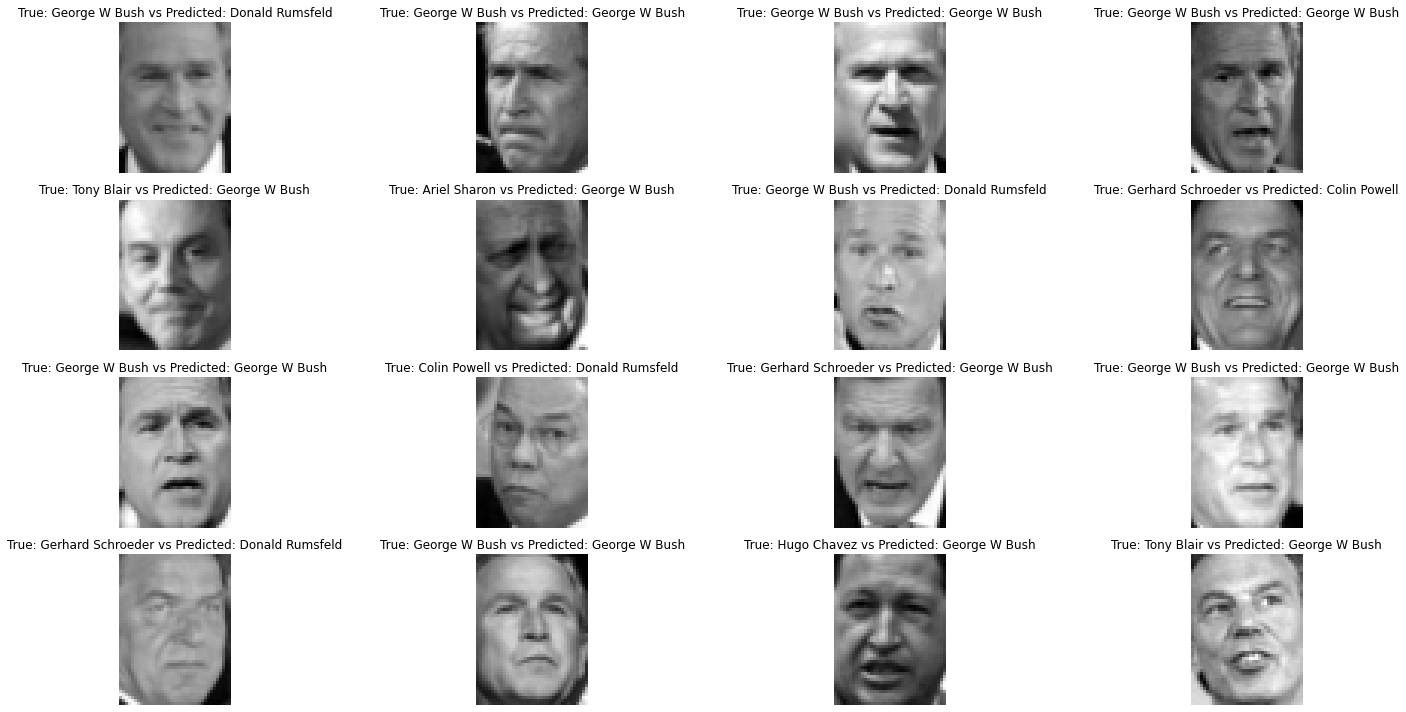

In [ ]:
# solution
fig, axs = plt.subplots(4, 4)
fig.set_size_inches(20, 10)
axs = axs.flatten()
for ax in axs:
    ax.axis('off')

test_indices = np.random.choice(X_test.shape[0], 16, replace=False)

for i in range(16):
    index = test_indices[i]
    transformed_image = np.expand_dims(standarized_transformed_test[index], axis=0)
    
    reshaped_original_image = np.reshape(X_test[index], (h, w))
    prediction = best_estimator.predict(transformed_image)
    
    axs[i].imshow(reshaped_original_image, cmap='gray')
    axs[i].set_title(create_title(prediction, y_test[index]))

fig.tight_layout()

*   What are the disadvantages of using kNN

**Solution**

* As explained above, K-NN needs the different features to be normalized/standarized to ensure the distances between points are correctly computed and no feature has more weight than another.
* We have to decide the optimal number of neighbours to consider, as choosing a big or small element can suppose considerable differences. Also, we have to decide the distance metric, as well as the voting scheme to decide the final label. That is, we have some parameters that need to be tuned for each dataset.
* As seen before, K-NN has problems with class imbalance. Given that we need to select among the nearest neighbours the final label, if we have very few instances in the train set from one class, it is more difficult to correctly predict new instances of that class.
* The K-NN algorithm is not really efficient, given that for each point we need to compute the distance to the other points, meaning that it has a $O(n^2)$ temporal cost. It also needs a considerable amount of memory, as we need all the dataset loaded every time to compute the distances between elements. That is, it suffers from the curse of dimensionality.
* Given that it computes distances between points, it is really sensitive to outliers and noise. Also, it is not able to deal with missing data, as we need all the values defined when computing distances.


---

# **End of P3: Face Detection and Recognition**
Deadline for P3 submission in CampusVirtual is: **Monday, the 22nd of November, 2021**